In [1]:
#basics
import numpy as np 
import pandas as pd
import collections
import re
import functools
import operator
from datetime import datetime, timedelta
from accessify import protected
from copy import deepcopy

#NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from string import punctuation
nltk.download("stopwords")
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.manifold import TSNE
from nltk import ngrams

#visualise
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
#import plotly.graph_obs as go
from plotly.offline import iplot
import cufflinks as cf
import matplotlib.cm as cm
import plotly.express as px


#fastai
from sklearn.model_selection import train_test_split
import fastai
from fastai.text.transform import Tokenizer
from fastai.text.learner import text_classifier_learner
from fastai.text.models import AWD_LSTM
from fastai.text.models import awd_lstm_lm_config


#extra
noise = stopwords.words('russian') + list(punctuation)
upnoise = [letter.upper() for letter in noise]
sum_noise = noise+upnoise+['.','»','«', 'Коллега', "коллега", "это",'спасибо', 
                           'такой',"уважаемый", "квартира", "который", "свой", "пожалуйста"]
path = ''

[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/home/victor/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)



In [2]:
df = pd.read_csv("fb1.csv", index_col=0)
df = df.drop(columns=['entry_id', 'hash_sum', 'tech_load_ts'])
df = df.dropna()
df.index = np.arange(len(df))

In [12]:
df['comment'][1]

"['2 млн лучше брать в кредит', 'KarnestoУ меня была аналогичная ситуация, клиентка инвестор, которая со мною провела уже достаточно много сделок с недвижимостью в том же сбере', 'услышать домклик', 'Шишкина Хотеть не вредно . По-моему, стремление общаться через Домклик и с Домкликом, как с абсолютно лишним звеном на рынке недвижимости, чаще мешающим, чем помогающим проведению сделок - это просто мазохизм . Стараюсь держаться от всего это...Ещё', 'нас похожая ситуация, говорят про риск, но не говорят какой . В документах все прозрачно, хотя есть ребенок-собственник, но есть разрешение опеки . Кредитных средств 30% всего', 'Сбербанк реагирует на свой хэштег . Но тут видимо сказать нечего (( а я уже нашла другого продавца и ипотека не понадобится.', 'хорошо . Но кто зрители, и как вы хотите принудить их смотреть это шесть минут и зачем?', 'Демин Снято для соискателей, которые не дошли до собеседования . Задача - показать как у нас проходят понедельники )']"

In [5]:
class SentimentalModel:
    
    def __init__(self, pos='positive_senti.csv', neg='negative_senti.csv'):
        self.pos = pos
        self.neg = neg
        
    def token_text(self, text):
        return [word for word in word_tokenize(text.lower()) if word not in sum_noise]
    
    def preprocess_text(self, text):
        text = text.lower().replace("ё", "е")
        text = text.lower().replace("USER", "")
        text = text.lower().replace("rt", "")
        text = text.lower().replace("URL", "")
        text = text.lower().replace("", "")
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
        text = re.sub('@[^\s]+', 'USER', text)
        text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
        text = re.sub(' +', ' ', text)
        return text.strip()
    
    def create_data(self):
        n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
        data_positive = pd.read_csv(self.pos, sep=';', error_bad_lines=False, names=n, usecols=['text'])
        data_negative = pd.read_csv(self.neg, sep=';', error_bad_lines=False, names=n, usecols=['text'])

        # Формируем сбалансированный датасет
        sample_size = min(data_positive.shape[0], data_negative.shape[0])
        raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                                   data_negative['text'].values[:sample_size]), axis=0)
        self.labels = [1] * sample_size + [0] * sample_size
        
        
        self.data = [self.preprocess_text(t) for t in raw_data]
        self.data_tok = pd.Series(self.data).apply(self.token_text)

        self.WORDS = set()
        for sent in self.data_tok:
            for w in sent:
                self.WORDS.add(w)
                
                
        df_train=pd.DataFrame(columns=['Text', 'Label'])
        df_test=pd.DataFrame(columns=['Text', 'Label'])

        df_train['Text'], df_test['Text'], df_train['Label'], df_test['Label'] = train_test_split(self.data,
                                                                                                  self.labels,
                                                                                                  test_size=0.2,
                                                                                                  random_state=1)
        
        df_val=pd.DataFrame(columns=['Text', 'Label'])
        self.df_train, self.df_val = train_test_split(df_train, test_size=0.2, random_state=1)
        
        print('data created')
        
    def fit(self):
        
        self.create_data()
        
        
        
        tokenizer=Tokenizer(lang='xx')
        data_lm = fastai.text.data.TextLMDataBunch.from_df(path, tokenizer=tokenizer,
                                                   bs=16, train_df=self.df_train, valid_df=self.df_val,
                                                           text_cols=0)
        print('batches formed')
        
        data_test_clas = fastai.text.data.TextClasDataBunch.from_df(path, vocab=data_lm.train_ds.vocab,
                                                            bs=32, train_df=self.df_train, valid_df=self.df_val,
                                                            text_cols=0, label_cols=1, tokenizer=tokenizer)
        
        
        config = fastai.text.models.awd_lstm_clas_config.copy()
        config['n_hid'] = 1150
        self.learn_test =text_classifier_learner(data_test_clas, AWD_LSTM, config=config, drop_mult=0.5)
        
        self.learn_test.load_encoder('/home/victor/fb/ft_enc')
        self.learn_test.load('/home/victor/fb/tw_lstm')
        
        print('model learned')
        
    def predict(self, obj:'str'):
        
        return self.learn_test.predict(obj)

In [26]:
df['time'].value_counts()

2020-12-23    82
2020-12-07    75
2020-12-25    72
2020-12-21    69
2020-12-24    65
              ..
2020-10-28     1
2020-11-01     1
2019-07-12     1
2017-12-22     1
2020-10-25     1
Name: time, Length: 131, dtype: int64

In [6]:
mod = SentimentalModel()

In [7]:
mod.fit()

data created


/home/victor/anaconda3/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



batches formed


/home/victor/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

<string>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



model learned


In [8]:
mod.predict('плохо')

/home/victor/anaconda3/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



(Category tensor(0), tensor(0), tensor([0.9980, 0.0020]))

In [10]:
class TextAnalyzer:
    def __init__(self, df):
        ##########TIME#######################
        for i in range(len(df)):
            try:
                df['time'][i] = datetime.strptime(df["time"][i], '%Y-%m-%d')
            except TypeError:
                continue
            
        self.df = deepcopy(self.tokeniz(df))
        self.df2 = deepcopy(df)
        
    @protected
    def tokeniz(self, df):

        #########COMMENTS#####################
        for i in range(len(df)):
            df["comment"][i] = list(df["comment"][i][2:-2].replace("'", '').split(','))
        tw = TweetTokenizer()
        det = TreebankWordDetokenizer()
        for i in (range(len(df))):
            for j in range(len(df["comment"][i])):
                tokenized_example = (tw.tokenize(df["comment"][i][j]))
                filtered_example = [word for word in tokenized_example if not word in sum_noise]
                df["comment"][i][j] = det.detokenize(filtered_example)
        mystem_analyzer = Mystem(entire_input=False)
        for i in (range(len(df))):
            df["comment"][i] = [mystem_analyzer.lemmatize(w) for w in df["comment"][i]]
            df["comment"][i] = list(filter(None, df["comment"][i]))
        for i in range(len(df)):
            for j in range(len(df['comment'][i])):
                df['comment'][i][j] = [word for word in df['comment'][i][j] if not word in sum_noise]


        ##########POSTS##############
        for i in (range(len(df))):
                tokenized_example = (tw.tokenize(df["post"][i]))
                filtered_example = [word for word in tokenized_example if not word in sum_noise]
                df["post"][i] = det.detokenize(filtered_example)
        for i in (range(len(df))):
            a = []
            a.append(df['post'][i])
            df["post"][i] = a
        for i in (range(len(df))):
            df["post"][i] = [mystem_analyzer.lemmatize(w) for w in df["post"][i]][0]
        for i in range(len(df)):
            df['post'][i] = [word for word in df['post'][i] if not word in sum_noise]
        
        return df
    
    @protected
    def date_slice(self, start_date = None, end_date = None):
        if start_date == None and end_date == None:
                self.df1 = deepcopy(self.df)
        
        if (type(start_date) == list or type(end_date) == list):
            if (not start_date == None ) and (not end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = self.df[self.df['time']<end_date]
                self.df1 = self.df1[self.df1['time']>start_date]
            elif (not start_date == None ) and (end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                self.df1 = self.df[self.df['time']>start_date]
            elif (start_date == None ) and (not end_date==None):
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = self.df[self.df['time']<end_date]
        elif (type(start_date) == datetime  and type(end_date) == datetime):
            self.df1 = self.df[self.df['time']<end_date]
            self.df1 = self.df1[self.df1['time']>=start_date]
            
    @protected
    def date_slice1(self, df, start_date = None, end_date = None):
        if start_date == None and end_date == None:
                self.df1 = deepcopy(df)
        
        if (type(start_date) == list or type(end_date) == list):
            if (not start_date == None ) and (not end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = df[df['time']<end_date]
                self.df1 = self.df1[self.df1['time']>start_date]
            elif (not start_date == None ) and (end_date==None):
                start_date = datetime(start_date[2], start_date[1], start_date[0], 0, 0)
                self.df1 = df[df['time']>start_date]
            elif (start_date == None ) and (not end_date==None):
                end_date = datetime(end_date[2], end_date[1], end_date[0], 0, 0)
                self.df1 = df[df['time']<end_date]
        elif (type(start_date) == datetime  and type(end_date) == datetime):
            self.df1 = df[df['time']<end_date]
            self.df1 = self.df1[self.df1['time']>=start_date]
            
    def frequency(self,  numb, text_type, start_date = None, end_date = None, ngram = 1, draw=True, output=True):
        #start&end date = [d, m ,y]
        if ngram>1:
            draw = False
        self.numb = numb
        self.wordcount = {}
        self.text_type = text_type
        self.draw = draw
        #self.start_date = start_date
        #self.end_date = end_date
       
        self.date_slice1(self.df, start_date, end_date)
        
        if self.text_type == 'comment':
            
            self.df1.index = np.arange(len(self.df1))
            if ngram>1:
                for i in range(len(self.df1)):
                    for j in range(len(self.df1['comment'][i])):
                        self.df1['comment'][i][j] = list(ngrams(self.df1['comment'][i][j],ngram))
            for i in range(len(self.df1)):
                for j in range(len(self.df1['comment'][i])):
                    for word in (self.df1['comment'][i][j]):
                       # if ngram==1:
                        #    word = word.replace(".","")
                         #   word = word.replace(",","")
                          #  word = word.replace(":","")
                           # word = word.replace("\"","")
                           # word = word.replace("!","")
                           # word = word.replace("â€œ","")
                           # word = word.replace("â€˜","")
                           # word = word.replace("*","")
                           # word = word.replace(" ","")
                        if word not in sum_noise:
                            if word not in self.wordcount.keys():
                                self.wordcount[word] = 1
                            else:
                                self.wordcount[word] += 1
        if self.text_type == 'post':
            self.df1.index = np.arange(len(self.df1))
            if ngram>1:
                for i in range(len(self.df1)):
                    self.df1['post'][i] = list(ngrams(self.df1['post'][i],ngram))
            for i in range(len(self.df1)):   
                for word in self.df1['post'][i]:
                  #  if ngram==1:
                   #     word = word.replace(".","")
                    ##    word = word.replace(",","")
                     #   word = word.replace(":","")
                     #   word = word.replace("\"","")
                     #   word = word.replace("!","")
                     #   word = word.replace("â€œ","")
                     #   word = word.replace("â€˜","")
                     #   word = word.replace("*","")
                     #   word = word.replace(" ","")
                    if word not in sum_noise:
                        if word not in self.wordcount.keys():
                            self.wordcount[word] = 1
                        else:
                            self.wordcount[word] += 1
        self.word_counter = collections.Counter(self.wordcount)
        if output:
            print("{} наиболее часто встречающихся слов\n".format(self.numb))
            for word, count in self.word_counter.most_common(self.numb):
                print(word, ": ", count)
        if self.draw:
            lst = self.word_counter.most_common(self.numb)
            df_cnt = pd.DataFrame(lst, columns = ['Word', 'Count'])
            plt.figure(figsize=(20, 12))
            plt.bar(df_cnt['Word'], df_cnt['Count'])
        if ngram>1:
            global df 
            df = pd.read_csv("fb.csv", index_col=0)
            tokeniz(df)
            self.df = df
    def date_top(self, text_type, nmb, start_date = None, end_date = None, draw = False):
        self.date_slice1(self.df, start_date, end_date)
            
        self.dates = np.sort(self.df1['time'].unique())
        self.top_words = []
        print("Самое частое слово за день\n")
        for i in range(len(self.dates)):
            self.frequency(nmb, text_type, start_date = self.dates[i], end_date = self.dates[i]+timedelta(days=1), draw = draw, output=False)
            #self.top_words.append(self.word_counter.most_common(1)[0][0])
            if not len(self.word_counter.most_common(nmb)) == 0:
                print(self.word_counter.most_common(nmb), self.dates[i].date(), '\n')
            else:
                print('no comments', self.dates[i].date(), '\n')
    def word_in_time(self, word):
        self.word = word
        self.dates = np.sort(self.df['time'].unique())
        self.wrd_cnt = []
        for i in range(len(self.dates)):
            self.count = 0
            self.dfwrd = self.df[self.df['time'] == self.dates[i]]
            self.dfwrd.index = np.arange(len(self.dfwrd))
            for j in range(len(self.dfwrd)):
                for word1 in self.dfwrd['post'][j]:
                    if word1 == self.word:
                        self.count +=1
                for comm in self.dfwrd['comment'][j]:
                    for word2 in comm:
                        if word2 == self.word:
                            self.count +=1
            self.wrd_cnt.append(self.count)
        self.plots = pd.DataFrame(self.wrd_cnt, columns=['Количество упоминаний'])
        self.plots['Дата'] = self.dates
        f = plt.figure(figsize=(19, 15))
        fig = px.line(self.plots, x='Дата', y = 'Количество упоминаний', title = 'Встречаемость слова "{}" во времени'.format(word))
        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        )
        fig.show()
        
    def date_unique(self, nmb, start_date = None, end_date = None):
        self.date_slice1(self.df, start_date, end_date)
        self.df1_nd = deepcopy(self.df.iloc[np.delete(np.arange(len(self.df)), self.df1.index),:])
        self.df1.index = np.arange(len(self.df1))
        self.nmb = nmb
        self.d = ''
        det = TreebankWordDetokenizer()
        for i in range(len(self.df1)):
            self.d += ' ' + det.detokenize(self.df1['post'][i])
        for i in range(len(self.df1)):
            for j in range(len(self.df1['comment'][i])):
                self.d += ' ' + det.detokenize(self.df1['comment'][i][j])
        self.df1_nd.index = np.arange(len(self.df1_nd))
        self.nd = ''
        for i in range(len(self.df1_nd)):
            self.nd += ' ' + det.detokenize(self.df1_nd['post'][i])
        for i in range(len(self.df1_nd)):
            for j in range(len(self.df1_nd['comment'][i])):
                self.nd += ' ' + det.detokenize(self.df1_nd['comment'][i][j])
        self.ls_dt = [self.d, self.nd]
        vectorizer = TfidfVectorizer()
        self.X = vectorizer.fit_transform(self.ls_dt)
        self.tt = pd.DataFrame(self.X.toarray(), columns=vectorizer.get_feature_names())
        self.dick = dict(zip(self.tt.columns, self.tt.loc[0]))
        self.utp = sorted(self.dick, key=self.dick.get, reverse=True)
        print ('{} самых значимых слов для данного промежутка\n'.format(self.nmb))
        for i in range(nmb):
            print('{}:'.format(i+1)+' '+self.utp[i])
    def context(self, word, start_date = None, end_date = None, k = 15, ngram = 1, draw=True):
        self.date_slice1(self.df, start_date, end_date)
        self.closest = []
        if ngram ==1:     
            for i in range(len(self.df1)):
                j = 0
                try:
                    index = self.df1['post'][i][j:].index(word)
                    if index>k:
                        if len(self.df1['post'][i][j:][index:])>k:
                            context_ls = self.df1['post'][i][j:][index-k:index+k]
                        elif len(self.df1['post'][i][j:][index:])<=k:
                            context_ls = self.df1['post'][i][j:][index-k:]
                    elif index<=k:
                        if len(self.df1['post'][i][j:][index:])>k:
                            context_ls = self.df1['post'][i][j:][:index+k]
                        elif len(self.df1['post'][i][j:][index:])<=k:
                            context_ls = self.df1['post'][i][j:][:]
                    self.closest.append(context_ls)
                    j = index
                except ValueError:
                    continue
            for i in range(len(self.df1)):
                for f in range(len(self.df1['comment'][i])):
                    j = 0
                    try:
                        index = self.df1['comment'][i][f][j:].index(word)
                        if index>k:
                            if len(self.df1['comment'][i][f][j:][index:])>k:
                                context_ls = self.df1['comment'][i][f][j:][index-k:index+k]
                            elif len(self.df1['comment'][i][f][j:][index:])<=k:
                                context_ls = self.df1['comment'][i][f][j:][index-k:]
                        elif index<=k:
                            if len(self.df1['comment'][i][f][j:][index:])>k:
                                context_ls = self.df1['comment'][i][f][j:][:index+k]
                            elif len(self.df1['comment'][i][f][j:][index:])<=k:
                                context_ls = self.df1['comment'][i][f][j:][:]
                        self.closest.append(context_ls)
                        j = index
                    except ValueError:
                        continue
            self.wordcount_contxt = {}
            for i in range(len(self.closest)):   
                        for word in self.closest[i]:
                            word = word.replace(".","")
                            word = word.replace(",","")
                            word = word.replace(":","")
                            word = word.replace("\"","")
                            word = word.replace("!","")
                            word = word.replace("â€œ","")
                            word = word.replace("â€˜","")
                            word = word.replace("*","")
                            if word not in sum_noise:
                                if word not in self.wordcount_contxt:
                                    self.wordcount_contxt[word] = 1
                                else:
                                    self.wordcount_contxt[word] += 1
            print("{} наиболее часто встречающихся слов контекста\n".format(k))
            self.wordcount_contxt.pop(word)
            word_counter = collections.Counter(self.wordcount_contxt)
            for word, count in word_counter.most_common(k):
                   print(word, ": ", count)
                
        if ngram>1:
            print('не работает, извините(')
            draw=False
            '''
            
            for i in range(len(self.df1)):
                    for j in range(len(self.df1['comment'][i])):
                        self.df1['comment'][i][j] = list(ngrams(self.df1['comment'][i][j],ngram))
            for i in range(len(self.df1)):
                    self.df1['post'][i] = list(ngrams(self.df1['post'][i],ngram))
                    
            self.contxt_ls = []
            for i in range(len(self.df1)):
                for j in range(len(self.df1['post'][i])):
                    if word in self.df1['post'][i][j]:
                        self.contxt_ls.append(self.df1['post'][i][j])
            for i in range(len(self.df1)):
                for j in range(len(self.df1['comment'][i])):
                    for f in range(len(self.df1['comment'][i][j])):
                        if word in self.df1['comment'][i][j][f]:
                            self.contxt_ls.append(self.df1['comment'][i][j][f])
            self.wordcount_contxt = {}
            for word in (self.contxt_ls):   
                if word not in sum_noise:
                    if word not in self.wordcount_contxt:
                        self.wordcount_contxt[word] = 1
                    else:
                        self.wordcount_contxt[word] += 1
            self.wordcount_contxt.pop(word)
            print("{} наиболее часто встречающихся слов контекста\n".format(k))
            word_counter = collections.Counter(self.wordcount_contxt)
            for word, count in word_counter.most_common(k):
                   print(word, ": ", count) 
            
            global df
            df = pd.read_csv("fb.csv", index_col=0)
            tokeniz(df)
            self.df = deepcopy(df)
            '''
        if draw:
            lst = word_counter.most_common(k)
            df_cnt = pd.DataFrame(lst, columns = ['Word', 'Count'])
            plt.figure(figsize=(20, 12))
            plt.bar(df_cnt['Word'], df_cnt['Count'])

    def visualise_context(self, keys:"list", n, start_date=None, end_date=None, min_cnt = 5, wind = 20, 
                         draw=True, title='Context Visualisation', a=0.7):
        
        self.date_slice1(self.df2, start_date, end_date)
        
        corpus = []
        for ls in self.df1['post']:
            corpus.append(ls)
        for i in range(len(self.df1)):
            for j in range(len(self.df1['comment'][i])):
                corpus.append(self.df1['comment'][i][j])
                
        
        self.keys = keys
        model = gensim.models.word2vec.Word2Vec(sentences = corpus, min_count = min_cnt, window=wind,
                                                workers=4)

        embedding_clusters = []
        word_clusters = []
        for word in keys:
            embeddings = []
            words = []
            for similar_word, _ in model.most_similar(word, topn=n):
                words.append(similar_word)
                embeddings.append(model[similar_word])
            words.append(word)
            embeddings.append(model[word])
            embedding_clusters.append(embeddings)
            word_clusters.append(words)
        embedding_clusters = np.array(embedding_clusters)
        n, m, k = embedding_clusters.shape
        try:
            tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
            embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        except:
            tsne_model_en_2d = TSNE(perplexity=15, n_components=2, n_iter=3500, random_state=32)
            embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        
        if draw:
            
            plt.figure(figsize=(20, 12))
            colors = cm.rainbow(np.linspace(0, 1, len(self.keys)))
            for label, embeddings, words, color in zip(self.keys, embeddings_en_2d, word_clusters, colors):
                x = embeddings[:, 0]
                y = embeddings[:, 1]
                plt.scatter(x, y, c=color.reshape(1,-1), alpha=a, label=label)
                for i, word in enumerate(words):
                    plt.annotate(word, alpha=3, xy=(x[i], y[i]), xytext=(5, 2),
                                 textcoords='offset points', ha='right', va='bottom', size=15)
            plt.legend(loc=4)
            plt.title(title)
            plt.grid(True)
            plt.show()


In [11]:
test = TextAnalyzer(df)

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:374: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:376: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:378: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



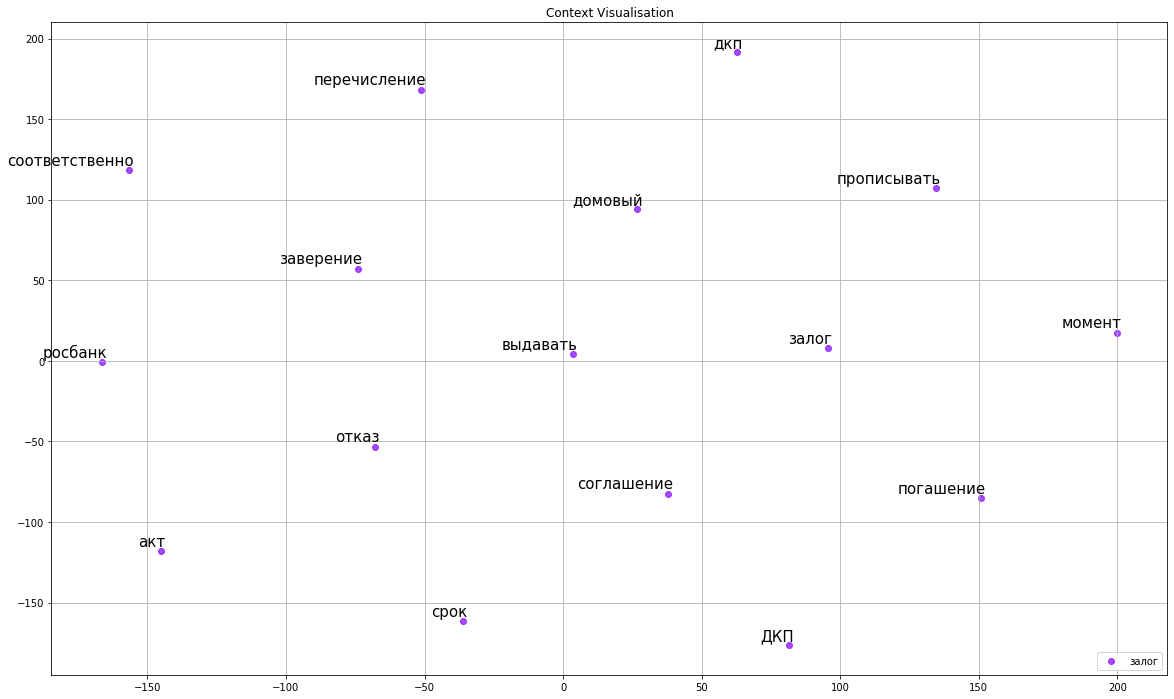

In [42]:
test.visualise_context(['залог'], 15)

25 наиболее часто встречающихся слов контекста

закладная :  53
банк :  19
обременение :  13
электронный :  13
день :  13
залог :  10
заявление :  10
снятие :  9
продавать :  9
росреестр :  9
писать :  9
открытие :  8
кредит :  8
менеджер :  8
доверенность :  8
МФЦ :  8
узнавать :  8
покупатель :  7
выдача :  7
ипотека :  6
проходить :  6
решать :  6
быстро :  6
месяц :  6
погасить :  5


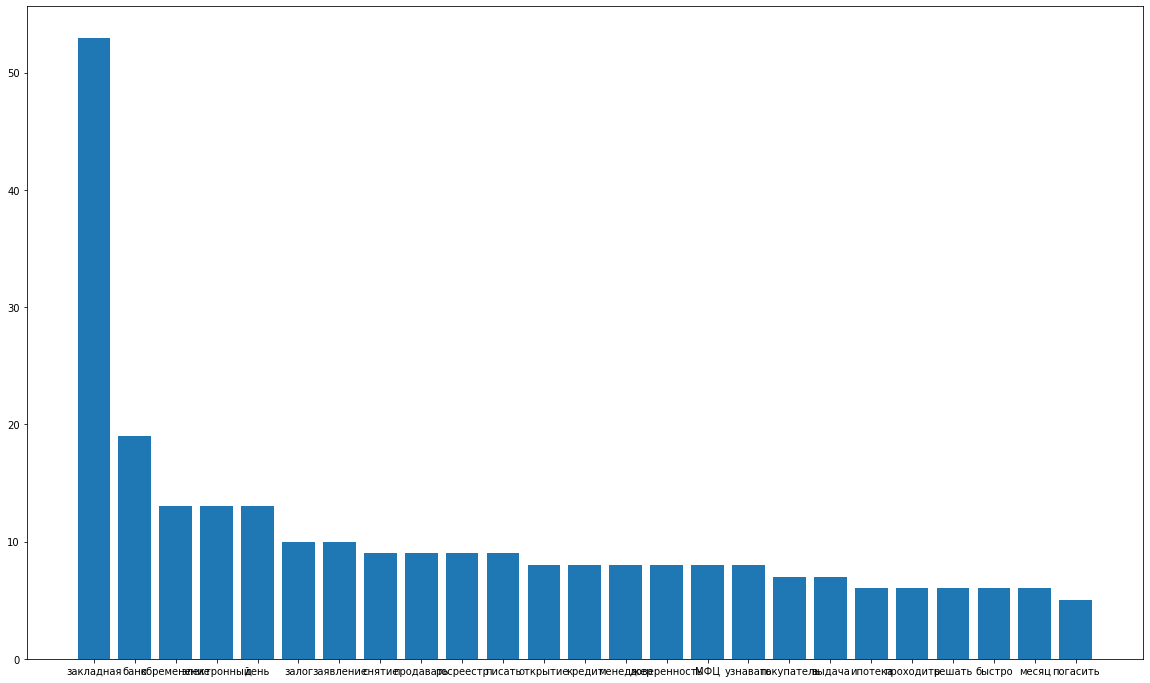

In [45]:
test.context('закладная', k=25, ngram=1)

20 наиболее часто встречающихся слов

сделка :  1355
покупатель :  1147
клиент :  1043
год :  989
деньги :  934
продавец :  925
договор :  865
продавать :  830
человек :  805
вопрос :  786
просто :  765
банк :  744
работать :  709
мочь :  691
понимать :  627
очень :  613
написать :  600
риэлтор :  594
делать :  591
ваш :  580


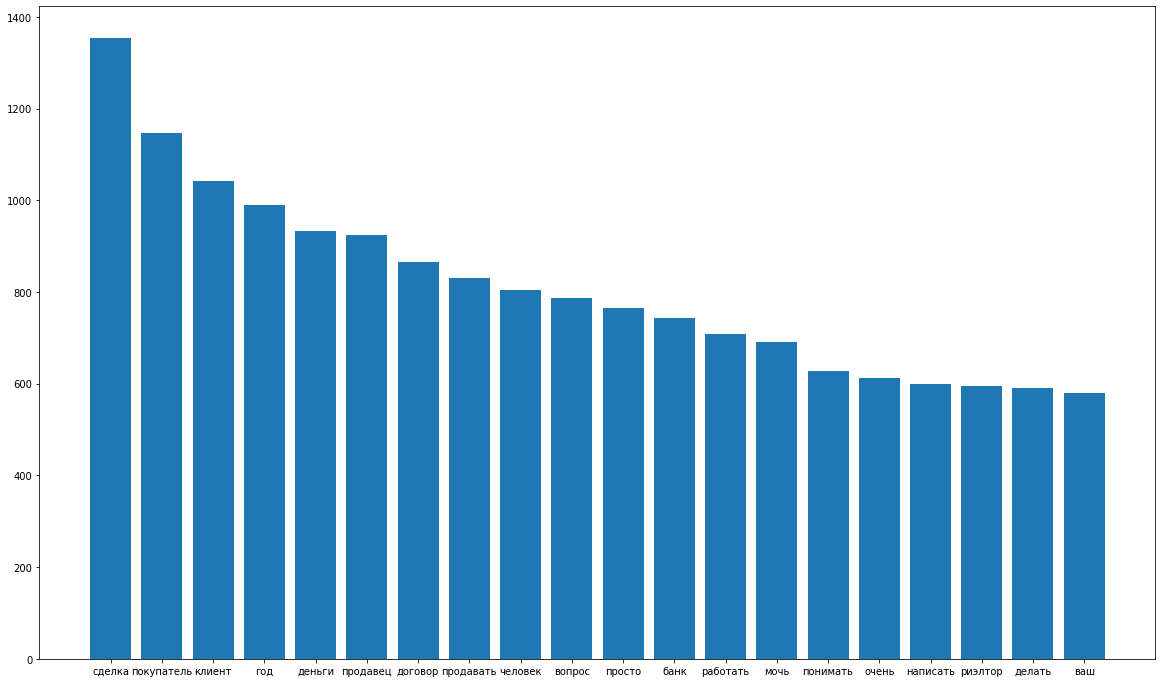

In [22]:
test.frequency(20, 'comment', start_date=[28,9,2020])

In [25]:
test.date_unique(15, start_date=[3,10,2020])

15 самых значимых слов для данного промежутка

1: сделка
2: покупатель
3: год
4: клиент
5: продавец
6: деньги
7: договор
8: продавать
9: вопрос
10: человек
11: банк
12: мочь
13: работать
14: риэлтор
15: день


In [17]:
test.date_top('comment', 1)

Самое частое слово за день

[('сделка', 12)] 2014-05-13 

[('домклик', 3)] 2017-09-11 

no comments 2017-09-12 

no comments 2017-09-14 

no comments 2017-09-20 

[('юлия', 4)] 2017-09-30 

[('проверять', 12)] 2017-10-11 

[('циан', 3)] 2017-10-13 

no comments 2017-11-23 

no comments 2017-12-22 

no comments 2018-04-02 

no comments 2018-04-10 

no comments 2018-09-19 

no comments 2018-12-24 

no comments 2019-07-12 

[('вводить', 2)] 2019-07-16 

no comments 2019-07-30 

[('сделка', 11)] 2019-08-19 

no comments 2019-08-26 

no comments 2019-08-29 

no comments 2019-09-15 

no comments 2019-09-24 

[('оценка', 4)] 2019-10-21 

no comments 2019-10-27 

[('клиент', 4)] 2019-11-21 

no comments 2019-11-22 

no comments 2020-02-22 

no comments 2020-04-24 

[('секс', 3)] 2020-05-20 

no comments 2020-07-02 

no comments 2020-07-20 

no comments 2020-07-22 

[('родитель', 13)] 2020-08-10 

[('писать', 6)] 2020-08-12 

no comments 2020-08-26 

no comments 2020-08-27 

no comments 2020-08

20 наиболее часто встречающихся слов контекста

гарантия :  62
давать :  10
никакой :  8
вопрос :  7
продавец :  6
покупатель :  5
аванс :  4
находить :  4
клиент :  4
сертификат :  4
работать :  4
новый :  4
платить :  4
нужный :  4
продавать :  4
просто :  4
друг :  4
сразу :  3
собственник :  3
ипотека :  3


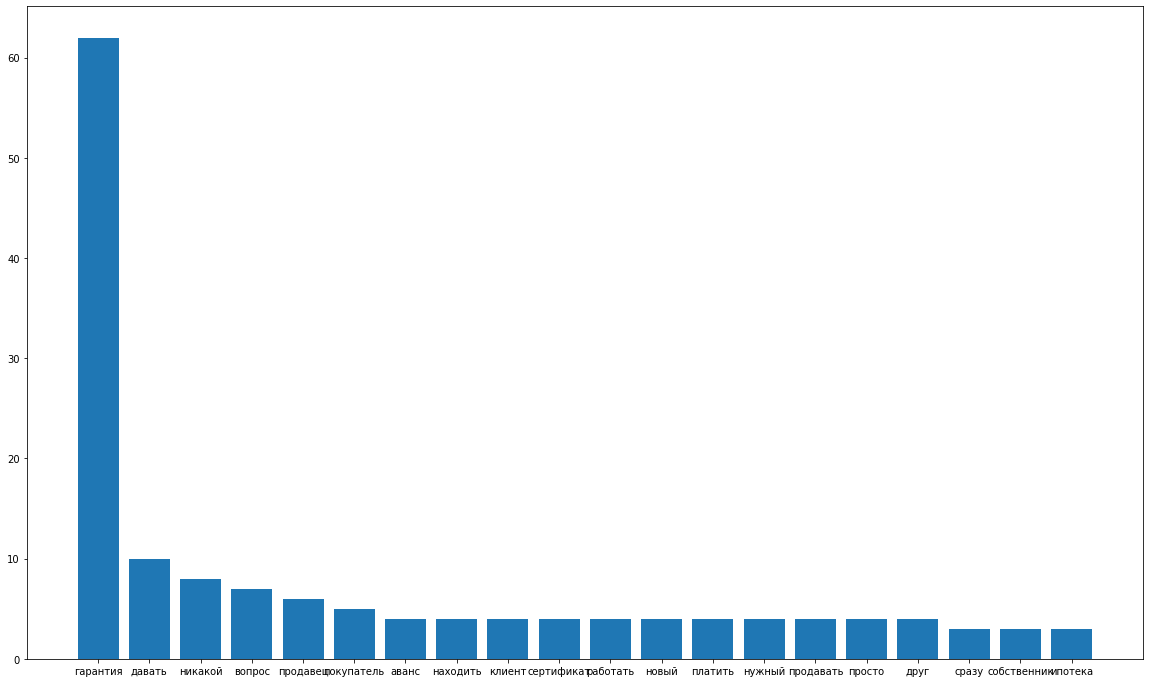

In [39]:
test.context('гарантия', k = 20, ngram=1) 

In [19]:
test.word_in_time('жопа') #наложить второй график

<Figure size 1368x1080 with 0 Axes>

In [18]:
test.context('право', k = 20, ngram=2)

не работает, извините(


In [15]:
import VV_TextAnalyzer as vv

[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
test = vv.TextAnalyzer(df)

In [ ]:
test.freq